In [12]:
import os
from datetime import datetime

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import docx
from docx import Document

In [13]:
CREATE_DOCX = True

# Assemble all JSON files into a single dataframe
RADEON = 'Radeon RX 6800 XT'
XAVIER = 'Xavier NX'
TESLA = 'Tesla V100'

directories = [
    {'device': XAVIER, 'path': os.path.join('..', '..', '03', 'measurements', '20241230-121548185') },
    {'device': TESLA,  'path': os.path.join('..', 'measurements', '20241231-094421118-fu') },
    {'device': RADEON, 'path': os.path.join('..','measurements','20241230-121631139-amd') }
]

DEVICE_ORDER = { s: idx for idx, s in zip(range(0, len(directories)), [ entry['device'] for entry in directories ]) }

In [14]:
outputDir = os.path.join('/home/jbecker', 'windows')

if CREATE_DOCX:
    outputDocx = Document()
    def createOutputDocxFilename():
        now = datetime.now()
        timestamp = now.strftime('%Y%m%d-%H%M%S') + f"{now.microsecond // 1000:03d}"
        return timestamp + '.docx'
    outputDocxFilename = os.path.join(outputDir, createOutputDocxFilename())

In [15]:
jsonData = []
for entry in directories:
    device = entry['device']
    jsonDirectory = entry['path']
    for filename in os.listdir(jsonDirectory):
        if not filename.endswith('.json'):
            continue
        filePath = os.path.join(jsonDirectory, filename)
        if not os.path.isfile(filePath):
            continue

        with open(filePath, 'r', encoding='utf-8') as file:
            data = json.load(file)
            jsonData.append({
                'device': device,
                'key': os.path.splitext(os.path.basename(filePath))[0],
                'data': data
            })

# Now jsonData is a list of records.

In [16]:
# Create a single Pandas dataframe from the list of records.
def createDfAll():
    def createDataframe(
        sourceKey,
        device,
        kernelKey,
        mappingLetter,
        uniformInput,
        inputFileName,
        inputLengthInCharacters,
        timesTransferToDevice,
        timesExecution,
        timesTransferFromDevice,
        bins
    ):
        n = len(timesExecution)
        df = pd.DataFrame({
            'sourceKey': [sourceKey] * n,
            'device': [device] * n,
            'kernel': [kernelKey.removeprefix('histogram_')] * n,
            'mappingLetter': [mappingLetter] * n,
            'uniformInput': [uniformInput] * n,
            'inputFileName': [inputFileName] * n,
            'inputLengthInCharacters': [inputLengthInCharacters] * n,
            'timeTransferToDevice': timesTransferToDevice,
            'timeExecution': timesExecution,
            'timeTransferFromDevice': timesTransferFromDevice,
            'timeTotal': None,
            'bins': [bins] * n
        })
        df['timeTotal'] = df['timeTransferToDevice'] + df['timeExecution'] + df['timeTransferFromDevice']
        return df

    dfs = []
    for entry in jsonData:
        device = entry['device']
        sourceKey = entry['key']
        rec = entry['data']
        inputLengthInCharacters = rec['inputLengthInCharacters']
        inputFileName = rec.get('fileName')
        uniformInput = rec['uniformInput']
        mappingLetter = rec['useMappingLetter']
        for k in rec['measurements'].keys():
            measurements = rec['measurements'][k]
            dfs.append(createDataframe(
                sourceKey,
                device,
                k,
                mappingLetter,
                uniformInput,
                inputFileName,
                inputLengthInCharacters,
                measurements['timesTransferToDevice'],
                measurements['timesExecution'],
                measurements['timesTransferFromDevice'],
                measurements['bins']
            ))
    dfAll = pd.concat(dfs)
    dfAll['device'] = pd.Categorical(dfAll['device'], categories=DEVICE_ORDER.keys(), ordered=True)
    return dfAll
dfAll = createDfAll()

In [17]:
dfAll.head()

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241230-121548185-112,Xavier NX,atomic_global,True,False,None,1073741824,157.593063,1710.349365,0.129344,1868.071773,"[637515449, 16780647, 16775927, 16778290, 1678..."
1,20241230-121548185-112,Xavier NX,atomic_global,True,False,None,1073741824,153.135010,1710.338013,0.130848,1863.603871,"[637515449, 16780647, 16775927, 16778290, 1678..."
2,20241230-121548185-112,Xavier NX,atomic_global,True,False,None,1073741824,149.195908,1710.331177,0.101152,1859.628236,"[637515449, 16780647, 16775927, 16778290, 1678..."
3,20241230-121548185-112,Xavier NX,atomic_global,True,False,None,1073741824,148.691971,1710.377930,0.092576,1859.162477,"[637515449, 16780647, 16775927, 16778290, 1678..."
4,20241230-121548185-112,Xavier NX,atomic_global,True,False,None,1073741824,147.412003,1710.361084,0.103840,1857.876927,"[637515449, 16780647, 16775927, 16778290, 1678..."


In [18]:
def getMeasurementsFor(
    df,
    device,
    mapping,
    inputType,
    kernels = None
):
    boolDevice = df['device'] == device
    if kernels is None:
        boolKernel = [True] * len(df['kernel'])
    else:
        if not isinstance(kernel, list):
            kernels = [kernels]
        boolKernel = df['kernel'].isin(kernels)
    if mapping == 'Mapping128':
        boolMapping = (df['mappingLetter'] == False)
    elif mapping == 'MappingLetter':
        boolMapping = (df['mappingLetter'] == True)
    else:
        raise RuntimeError('invalid mapping')
    if inputType == 'testfile':
        boolInputType = (df['inputFileName'].notna())
    elif inputType == 'uniform':
        boolInputType = (df['uniformInput'] == True) * (df['inputFileName'].isna())
    elif inputType == 'pseudorandom':
        boolInputType = (df['uniformInput'] == False) * (df['inputFileName'].isna())
    else:
        raise RuntimeError('invalid inputType')
    return df[boolDevice * boolKernel * boolMapping * boolInputType]

In [19]:
getMeasurementsFor(dfAll, RADEON, 'Mapping128', 'testfile', kernels=None)

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241230-121631139-000,Radeon RX 6800 XT,atomic_global,False,False,./input_data/test.txt,10532866,2.323308,1.043039,0.383493,3.749840,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
1,20241230-121631139-000,Radeon RX 6800 XT,atomic_global,False,False,./input_data/test.txt,10532866,0.773336,1.041129,0.018960,1.833425,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
2,20241230-121631139-000,Radeon RX 6800 XT,atomic_global,False,False,./input_data/test.txt,10532866,0.793047,1.043008,0.019560,1.855615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
3,20241230-121631139-000,Radeon RX 6800 XT,atomic_global,False,False,./input_data/test.txt,10532866,0.656135,1.043929,0.020080,1.720144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
4,20241230-121631139-000,Radeon RX 6800 XT,atomic_global,False,False,./input_data/test.txt,10532866,0.771796,1.049229,0.020000,1.841025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,20241230-121631139-000,Radeon RX 6800 XT,atomic_global_stride,False,False,./input_data/test.txt,10532866,0.694176,1.046018,0.024550,1.764744,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
96,20241230-121631139-000,Radeon RX 6800 XT,atomic_global_stride,False,False,./input_data/test.txt,10532866,0.656465,1.051878,0.020320,1.728663,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
97,20241230-121631139-000,Radeon RX 6800 XT,atomic_global_stride,False,False,./input_data/test.txt,10532866,0.654885,1.052138,0.023821,1.730844,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
98,20241230-121631139-000,Radeon RX 6800 XT,atomic_global_stride,False,False,./input_data/test.txt,10532866,0.655405,1.052438,0.023090,1.730933,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."


## Measurement results for test input file

In [20]:
dfTestFile = dfAll[dfAll['inputFileName'].notna()]

Number of characters in the test input file:

In [21]:
s = set(dfTestFile['inputLengthInCharacters'])
if len(s) != 1:
    raise RuntimeError('Something is wrong')
list(s)[0]

10532866

In [22]:
f'{list(s)[0] / 2 ** 20} MiB'

'10.044923782348633 MiB'

Distribution of characters in the test input file (bin counts under `Mapping128`):

In [23]:
binCounts = dfTestFile.iloc[0]['bins']

In [24]:
if CREATE_DOCX:
    def addToDocx(docxObj):
        bcNonZeroRel = [ { 'code': code + 1, 'h': h, 'f': h/sum(binCounts) } for code, h in zip(range(0, len(binCounts)), binCounts) if h != 0 ]
        table = docxObj.add_table(rows=len(bcNonZeroRel)+2, cols=3)
        hdrRow = table.rows[0].cells
        hdrRow[0].text = 'Code'
        hdrRow[1].text = 'Anzahl'
        hdrRow[2].text = 'relative Häufigkeit'
        for i, entry in enumerate(bcNonZeroRel):
            row = table.rows[i+1].cells
            code = entry['code']
            row[0].text = f'{code:0.0f}' + (f' (‘{chr(code)}’)' if code >= 32 else '')
            row[1].text = f'{entry["h"]:0.0f}'
            row[2].text = f'{entry["f"]*100:.3f} %'
            row[0].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
            row[1].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
            row[2].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        i = len(bcNonZeroRel) + 1
        lastRow = table.rows[i].cells
        lastRow[0].text = 'Summe'
        lastRow[1].text = f'{sum(binCounts):0.0f}'
        lastRow[2].text = f'100 %'
        lastRow[0].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        lastRow[1].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        lastRow[2].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        
    
    # outputDocx = docx.Document()
    addToDocx(outputDocx)
    outputDocx.save(outputDocxFilename)

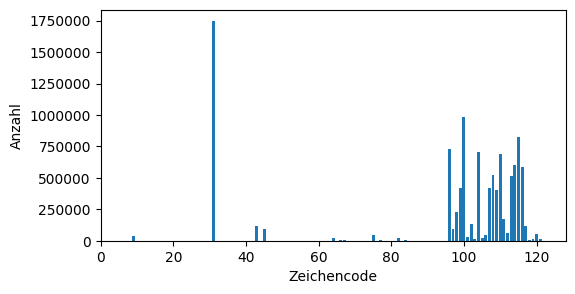

In [25]:
fig = plt.figure(figsize=(6,3))
plt.bar(list(range(0,len(binCounts))), binCounts)
plt.xlim(0, len(binCounts))
fig.axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Zeichencode')
plt.ylabel('Anzahl')
plt.show()

In [26]:
fig.savefig(os.path.join(outputDir, 'freqCharsTestTxt.svg'), format='svg', bbox_inches='tight')

Statistik:

In [27]:
def testFileMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfTestFile['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfTestFile['mappingLetter'] == True
    return dfTestFile[boolMapping].groupby(['device', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [28]:
stat128 = testFileMakeStatistics('Mapping128')
stat128

timeTransferToDevice            \
                                                         min       q10   
device            kernel                                                 
Xavier NX         atomic_global                     1.818048  1.840858   
                  atomic_global_stride              1.805984  1.874573   
                  atomic_private                    1.616832  1.889114   
                  atomic_private_stride             1.383744  1.450490   
Tesla V100        atomic_global                     6.615456  6.616019   
                  atomic_global_stride              6.616576  6.617149   
                  atomic_private                    6.615200  6.616154   
                  atomic_private_stride             6.616192  6.616957   
Radeon RX 6800 XT atomic_global                     0.649614  0.651382   
                  atomic_global_stride              0.647145  0.650891   
                  atomic_private                    0.649685  0.652638   
                  atomic_private_stride             0.644125  0.652105   

                                                                       \
                                              med       q90       max   
device            kernel                                                
Xavier NX         atomic_global          1.942304  1.942304  2.423968   
                  atomic_global_stride   1.983040  1.983040  2.194240   
                  atomic_private         2.030176  2.030176  2.675840   
                  atomic_private_stride  1.634784  1.634784  2.300384   
Tesla V100        atomic_global          6.617232  6.617232  6.665568   
                  atomic_global_stride   6.618288  6.618288  6.644320   
                  atomic_private         6.617472  6.617472  6.643872   
                  atomic_private_stride  6.618032  6.618032  6.643072   
Radeon RX 6800 XT atomic_global          0.668305  0.668305  2.323308   
                  atomic_global_stride   0.670130  0.670130  1.658591   
                  atomic_private         0.673351  0.673351  1.659642   
                  atomic_private_stride  0.656340  0.656340  1.665622   

                                        timeExecution                      \
                                                  min       q10       med   
device            kernel                                                    
Xavier NX         atomic_global              9.502528  9.571648  9.810208   
                  atomic_global_stride       9.546272  9.573888  9.610128   
                  atomic_private             2.018624  2.065830  2.121568   
                  atomic_private_stride      1.015968  1.032304  1.080192   
Tesla V100        atomic_global              3.231968  3.232989  3.233664   
                  atomic_global_stride       3.231584  3.233974  3.234656   
                  atomic_private             0.306656  0.307517  0.308352   
                  atomic_private_stride      0.065120  0.067005  0.068032   
Radeon RX 6800 XT atomic_global              1.041129  1.042815  1.043188   
                  atomic_global_stride       1.044118  1.046307  1.049358   
                  atomic_private             0.112881  0.114441  0.115721   
                  atomic_private_stride      0.062881  0.066304  0.067866   

                                                             \
                                              q90       max   
device            kernel                                      
Xavier NX         atomic_global          9.810208  9.910047   
                  atomic_global_stride   9.610128  9.767712   
                  atomic_private         2.121568  2.351680   
                  atomic_private_stride  1.080192  1.321952   
Tesla V100        atomic_global          3.233664  3.238688   
                  atomic_global_stride   3.234656  3.247488   
                  atomic_private         0.308352  0.321280   
                  atomic_private_stride  0.0680

In [29]:
statLetter = testFileMakeStatistics('MappingLetter')
statLetter

timeTransferToDevice            \
                                                         min       q10   
device            kernel                                                 
Xavier NX         atomic_global                     1.830016  1.896022   
                  atomic_global_stride              1.825216  1.880208   
                  atomic_private                    1.555552  1.787917   
                  atomic_private_stride             1.413312  1.490861   
Tesla V100        atomic_global                     6.616320  6.616797   
                  atomic_global_stride              6.616256  6.617494   
                  atomic_private                    6.616480  6.617168   
                  atomic_private_stride             6.616000  6.617113   
Radeon RX 6800 XT atomic_global                     0.749202  0.782010   
                  atomic_global_stride              0.780336  0.783291   
                  atomic_private                    0.777806  0.779324   
                  atomic_private_stride             0.776396  0.779821   

                                                                       \
                                              med       q90       max   
device            kernel                                                
Xavier NX         atomic_global          2.011648  2.011648  2.390144   
                  atomic_global_stride   1.963968  1.963968  2.193440   
                  atomic_private         2.017136  2.017136  2.525920   
                  atomic_private_stride  1.640544  1.640544  2.385184   
Tesla V100        atomic_global          6.617696  6.617696  6.665728   
                  atomic_global_stride   6.618848  6.618848  6.649344   
                  atomic_private         6.618304  6.618304  6.646816   
                  atomic_private_stride  6.618192  6.618192  6.648000   
Radeon RX 6800 XT atomic_global          0.797524  0.797524  2.120575   
                  atomic_global_stride   0.797316  0.797316  1.695992   
                  atomic_private         0.782441  0.782441  1.683943   
                  atomic_private_stride  0.782626  0.782626  1.681473   

                                        timeExecution                        \
                                                  min        q10        med   
device            kernel                                                      
Xavier NX         atomic_global             11.276736  11.290499  11.323952   
                  atomic_global_stride      11.311840  11.334416  11.370896   
                  atomic_private             2.057600   2.095552   2.142864   
                  atomic_private_stride      1.067552   1.105882   1.168880   
Tesla V100        atomic_global              3.853504   3.854621   3.855664   
                  atomic_global_stride       3.855552   3.856093   3.857136   
                  atomic_private             0.163456   0.164992   0.165760   
                  atomic_private_stride      0.065152   0.066550   0.067920   
Radeon RX 6800 XT atomic_global              1.281170   1.282987   1.283456   
                  atomic_global_stride       1.283589   1.284903   1.287594   
                  atomic_private             0.116841   0.118468   0.119196   
                  atomic_private_stride      0.068790   0.071948   0.072605   

                                                               \
                                               q90        max   
device            kernel                                        
Xavier NX         atomic_global          11.323952  11.456448   
                  atomic_global_stride   11.370896  11.499168   
                  atomic_private          2.142864   2.399296   
                  atomic_private_stride   1.168880   1.326784   
Tesla V100        atomic_global           3.855664   3.861120   
                  atomic_global_stride    3.857136   3.860544   
                  atomic_private          0.165760   0.171552 

In [30]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, stat128)
    outputDocx.add_paragraph()
    addToDocx(outputDocx, statLetter)
    outputDocx.save(outputDocxFilename)

### Untersuchung der Transferzeiten auf das Device

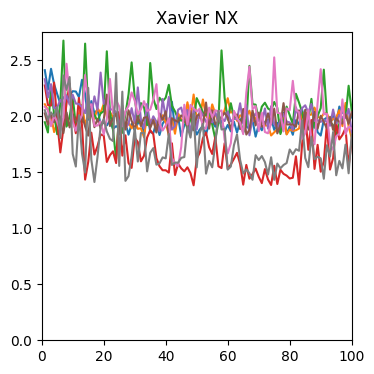

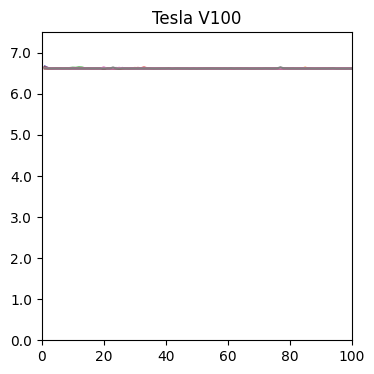

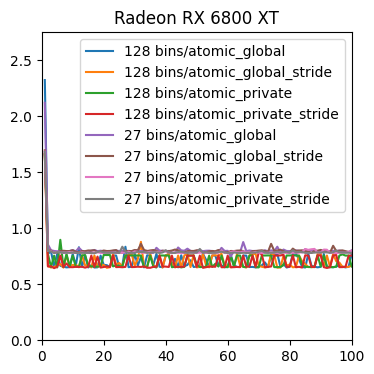

In [31]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(4,4))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeTransferToDevice']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{"27 bins" if mappingLetter else "128 bins"}/{name}')
    plt.xlim(0,len(c))
    if device == TESLA:
        plt.ylim(0,7.5)
    else:
        plt.ylim(0, 2.75)
    def format_func(value, tick_number):
        return f'{value:.1f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == RADEON:
        plt.legend()
    plt.show()

    abbrev = {
        RADEON: 'Radeon',
        TESLA: 'Tesla',
        XAVIER: 'Xavier'
    }
    fig.savefig(os.path.join(outputDir, f'transferHostDevice{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

### Untersuchung der Transferzeiten vom Device

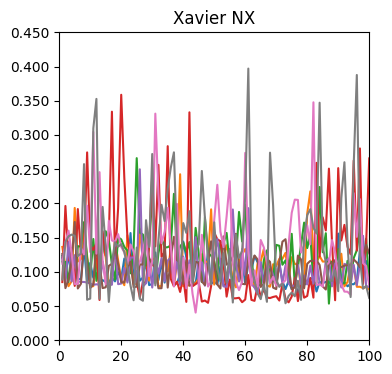

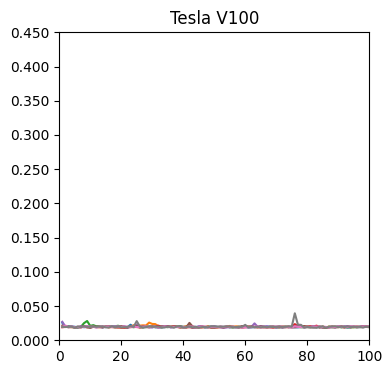

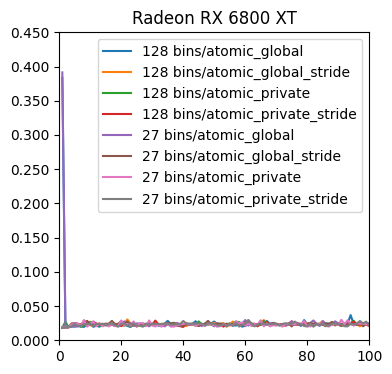

In [32]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(4,4))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeTransferFromDevice']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{"27 bins" if mappingLetter else "128 bins"}/{name}')
    plt.xlim(0,len(c))
    plt.ylim(0, 0.45)
    def format_func(value, tick_number):
        return f'{value:.3f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == RADEON:
        plt.legend()
    plt.show()

    abbrev = {
        RADEON: 'Radeon',
        TESLA: 'Tesla',
        XAVIER: 'Xavier'
    }    
    fig.savefig(os.path.join(outputDir, f'transferDeviceHost{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

### Untersuchung der Ausführungszeiten

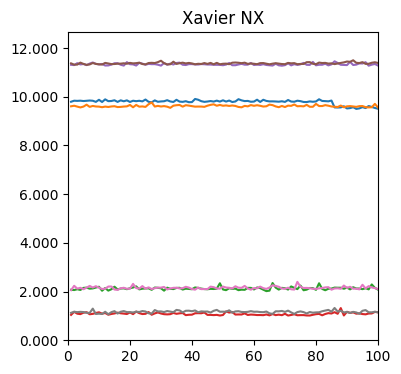

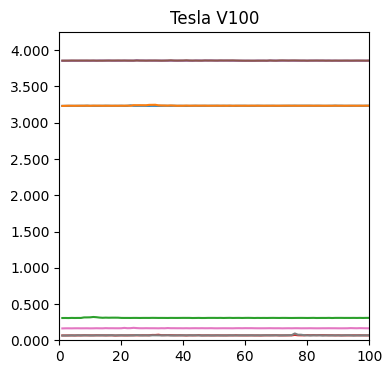

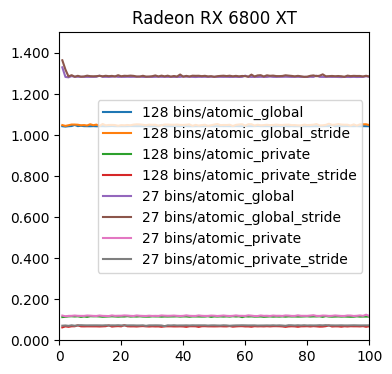

In [33]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(4,4))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeExecution']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{"27 bins" if mappingLetter else "128 bins"}/{name}')
    plt.xlim(0,len(c))
    plt.ylim(0, 1.1 * maxy)
    def format_func(value, tick_number):
        return f'{value:.3f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == RADEON:
        plt.legend()
    plt.show()

    abbrev = {
        RADEON: 'Radeon',
        TESLA: 'Tesla',
        XAVIER: 'Xavier'
    }    
    fig.savefig(os.path.join(outputDir, f'execution{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

Ausführungszeiten für die einzelnen Kernels für die beiden Mappings:

In [34]:
data1 = stat128['timeExecution']['med']
data2 = statLetter['timeExecution']['med']

data1.index = pd.MultiIndex.from_tuples([(x, 'Mapping128', z) for x, z in data1.index], names=['device', 'mapping', 'kernel'])
data2.index = pd.MultiIndex.from_tuples([(x, 'MappingLetter', z) for x, z in data2.index], names=['device', 'mapping', 'kernel'])
s = pd.concat([data1, data2]).sort_index(level=0).unstack(level=1).unstack(level=1)

s.index = pd.Categorical(s.index, categories=DEVICE_ORDER.keys(), ordered=True)
s = s.sort_index()
s

mapping              Mapping128                                      \
kernel            atomic_global atomic_global_stride atomic_private   
Xavier NX              9.810208             9.610128       2.121568   
Tesla V100             3.233664             3.234656       0.308352   
Radeon RX 6800 XT      1.043188             1.049358       0.115721   

mapping                                 MappingLetter                       \
kernel            atomic_private_stride atomic_global atomic_global_stride   
Xavier NX                      1.080192     11.323952            11.370896   
Tesla V100                     0.068032      3.855664             3.857136   
Radeon RX 6800 XT              0.067866      1.283456             1.287594   

mapping                                                 
kernel            atomic_private atomic_private_stride  
Xavier NX               2.142864              1.168880  
Tesla V100              0.165760              0.067920  
Radeon RX 6800 XT       0.119196              0.072605

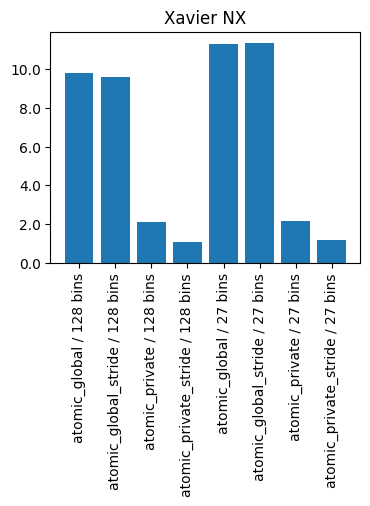

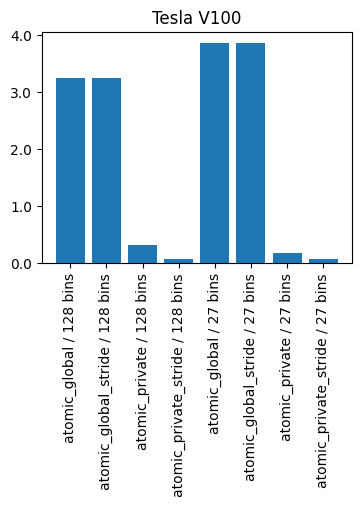

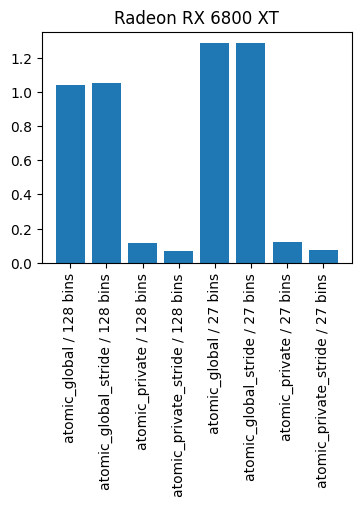

In [35]:
for r in range(0,s.shape[0]):
    heights = s.iloc[r]
    fig = plt.figure(figsize=(4,3))
    plt.bar([
        f'{name} / {"27 bins" if mapping == "MappingLetter" else "128 bins"}' for mapping, name in s.columns
    ], heights)
    plt.xticks(rotation=90)
    def format_func(value, tick_number):
        return f'{value:.1f}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    device = s.index[r]
    plt.title(device)
    plt.show()

    abbrev = {
        RADEON: 'Radeon',
        TESLA: 'Tesla',
        XAVIER: 'Xavier'
    }    
    fig.savefig(os.path.join(outputDir, f'executionBar{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

Speedup in den Ausführungszeiten:

In [36]:
OTPC = 'atomic_global'
speedup = s.copy() # probably inefficient way of copying the layout of the dataframe
for m in set(s.columns.get_level_values(0)):
    n = s[(m, OTPC)]
    for h in set(s.columns.get_level_values(1)):
        speedup[(m, h)] = n / s[(m, h)]
speedup

mapping              Mapping128                                      \
kernel            atomic_global atomic_global_stride atomic_private   
Xavier NX                   1.0             1.020820       4.624036   
Tesla V100                  1.0             0.999693      10.486924   
Radeon RX 6800 XT           1.0             0.994121       9.014686   

mapping                                 MappingLetter                       \
kernel            atomic_private_stride atomic_global atomic_global_stride   
Xavier NX                      9.081911           1.0             0.995872   
Tesla V100                    47.531515           1.0             0.999618   
Radeon RX 6800 XT             15.371298           1.0             0.996785   

mapping                                                 
kernel            atomic_private atomic_private_stride  
Xavier NX               5.284494              9.687865  
Tesla V100             23.260521             56.767727  
Radeon RX 6800 XT      10.767605             17.677233

In [37]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.2f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, speedup)
    outputDocx.add_paragraph()
    
    outputDocx.save(outputDocxFilename)

In [38]:
letterPenalty = pd.DataFrame({
    h: s[('MappingLetter', h)] / s[('Mapping128', h)] for h in s.columns.get_level_values(1)
})

In [39]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, letterPenalty)
    outputDocx.add_paragraph()
    
    outputDocx.save(outputDocxFilename)

## Measurement results for generated data

In [40]:
dfGenerated = dfAll[dfAll['inputFileName'].isna()]

Distribution of characters for input size of 2^30 (= 1 GiB):

In [41]:
counts = dfGenerated[
    (dfGenerated['inputLengthInCharacters']==2**30) *
    (dfGenerated['uniformInput'] == False)
]['bins'].iloc[0]
print('rel. dev. ', (max(counts) - min(counts)) / sum(counts))
print('min rel. freq. ', max(counts) / sum(counts))
print('max rel. freq. ', max(counts) / sum(counts))

rel. dev.  0.578113560564816
min rel. freq.  0.5937325293198228
max rel. freq.  0.5937325293198228


In [42]:
def createStatisticsForGeneratedData(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfGenerated['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfGenerated['mappingLetter'] == True
    else:
        raise RuntimeError('Invalid parameter value: mapping')
    #boolUniform = dfGenerated['uniformInput'] == uniform
    return dfGenerated[
        boolMapping #* boolUniform
    ].groupby(['device', 'uniformInput', 'inputLengthInCharacters', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [43]:
genStat128 = createStatisticsForGeneratedData('Mapping128')
genStat128

timeTransferToDevice  \
                                                                                              min   
device            uniformInput inputLengthInCharacters kernel                                       
Xavier NX         False        8                       atomic_global                     0.018880   
                                                       atomic_global_stride              0.017088   
                                                       atomic_private                    0.018656   
                                                       atomic_private_stride             0.018208   
                               16                      atomic_global                     0.017504   
...                                                                                           ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride           162.859451   
                               4294967296              atomic_global                          NaN   
                                                       atomic_global_stride            297.827698   
                                                       atomic_private                         NaN   
                                                       atomic_private_stride           295.289337   

                                                                                          \
                                                                                     q10   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.019200   
                                                       atomic_global_stride     0.018621   
                                                       atomic_private           0.019261   
                                                       atomic_private_stride    0.018909   
                               16                      atomic_global            0.017821   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  170.119548   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   305.766876   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  296.933633   

                                                                                          \
                                                                                     med   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.021872   
                                                       atomic_global_stride     0.019744   
                                                       atomic_private           0.020512   
                                                       atomic_private_stride    0.026000   
                               16                      atomic_global            0.018864   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  172.847633   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   307.538620   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  305.861847   

                                                                                    

In [44]:
genStatLetter = createStatisticsForGeneratedData('MappingLetter')
genStatLetter

timeTransferToDevice  \
                                                                                              min   
device            uniformInput inputLengthInCharacters kernel                                       
Xavier NX         False        8                       atomic_global                     0.017664   
                                                       atomic_global_stride              0.017216   
                                                       atomic_private                    0.018240   
                                                       atomic_private_stride             0.017152   
                               16                      atomic_global                     0.017248   
...                                                                                           ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride           184.168594   
                               4294967296              atomic_global                          NaN   
                                                       atomic_global_stride            261.423981   
                                                       atomic_private                         NaN   
                                                       atomic_private_stride           261.453705   

                                                                                          \
                                                                                     q10   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.018333   
                                                       atomic_global_stride     0.018013   
                                                       atomic_private           0.018685   
                                                       atomic_private_stride    0.018557   
                               16                      atomic_global            0.017568   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  186.487984   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   264.674985   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  262.684766   

                                                                                          \
                                                                                     med   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.018944   
                                                       atomic_global_stride     0.018864   
                                                       atomic_private           0.019424   
                                                       atomic_private_stride    0.019664   
                               16                      atomic_global            0.018768   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  188.479050   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   266.087723   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  265.374344   

                                                                                    

In [45]:
if CREATE_DOCX:
    def addToDocx(docxObj, dff):
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    def reduceGenStat(genStat):
        gs = genStat.reset_index()
        return gs[gs[('inputLengthInCharacters','')].isin(
            [2 ** i for i in range(8,32+8,8)]
        )].drop([(a,b) for a, b in gs.columns if a == 'timeTransferFromDevice'], axis=1)
    genStat128Reduced = reduceGenStat(genStat128)
    genStatLetterReduced = reduceGenStat(genStatLetter)
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, genStat128Reduced)
    outputDocx.add_paragraph()
    addToDocx(outputDocx, genStatLetterReduced)
    outputDocx.save(outputDocxFilename)

In [72]:
def createPlotsForGeneratedData(genStat, mappingAbbrev):
    grouped = genStat.reset_index().groupby('device')

    col = {
        (False, 'atomic_global'): 'green',
        (True, 'atomic_global'): 'darkgreen',
        (False, 'atomic_private'): 'blue',
        (True, 'atomic_private'): 'darkblue',
        (False, 'atomic_private_stride'): 'orange',
        (True, 'atomic_private_stride'): 'darkorange',
        (False, 'atomic_global_stride'): 'brown',
        (True, 'atomic_global_stride'): 'black',
    }

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        by_kernel = grp.groupby(['uniformInput', 'kernel'])
        for (uniform, kernel), g in by_kernel:
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q10')], color=col[(uniform, kernel)], linestyle='--')
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'med')], color=col[(uniform, kernel)])
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q90')], color=col[(uniform, kernel)], linestyle='--')
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        plt.xlim(2 ** 3)
        plt.ylim(10 ** -2, 10 ** 4)
        plt.title(f'{device} / {"128" if mappingAbbrev == "128" else "27"} Bins')
        plt.show()

        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'execution{abbrev[device]}{mappingAbbrev}Generated.svg'), format='svg', bbox_inches='tight')

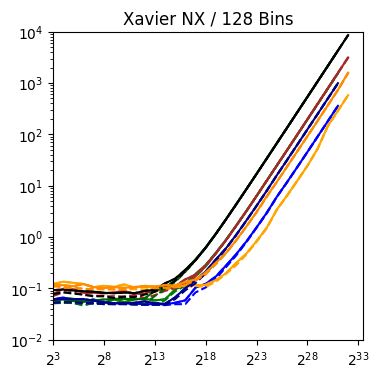

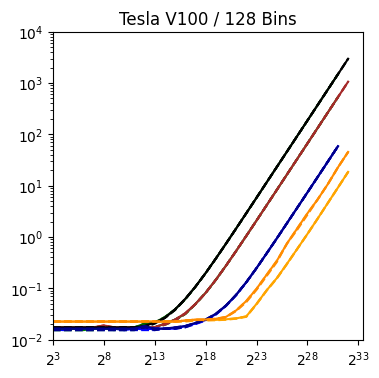

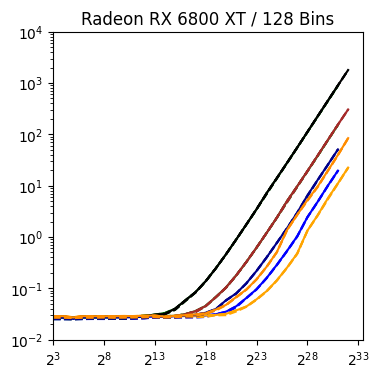

In [73]:
createPlotsForGeneratedData(genStat128, '128')

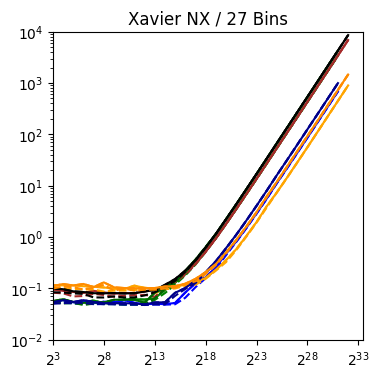

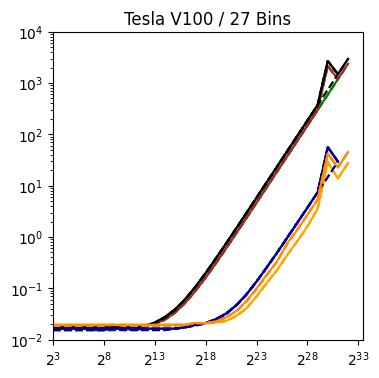

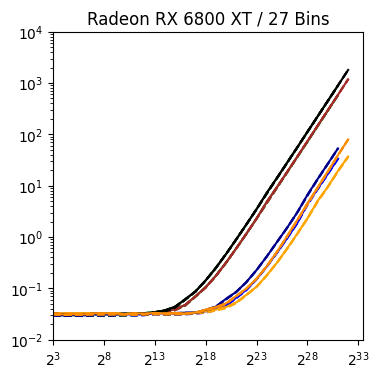

In [74]:
createPlotsForGeneratedData(genStatLetter, 'Letter')

In [86]:
def calculateSpeedups(genStat):
    s = genStat.loc[:,('timeExecution', 'med')].unstack(level=1).unstack(level=2)
    OTPC = 'atomic_global'
    speedup = s.copy() # probably inefficient way of copying the layout of the dataframe

    for m in set(s.columns.get_level_values(0)):
        n = s[(m, OTPC)]
        for h in set(s.columns.get_level_values(1)):
            speedup[(m, h)] = n / s[(m, h)]
    return speedup

In [88]:
speedupsGenStat128 = calculateSpeedups(genStat128)
speedupsGenStat128

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                                 1.0             0.778852   
                  16                                1.0             0.660662   
                  32                                1.0             0.651891   
                  64                                1.0             0.656970   
                  128                               1.0             0.747852   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                         1.0             0.993411   
                  536870912                         1.0             0.986152   
                  1073741824                        1.0             0.989639   
                  2147483648                        1.0             0.987231   
                  4294967296                        NaN                  NaN   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             0.979899   
                  16                            0.970878   
                  32                            1.092127   
                  64                            0.952179   
                  128                           1.019436   
...                                                  ...   
Radeon RX 6800 XT 268435456                     7.856082   
                  536870912                     7.862057   
                  1073741824                    7.680111   
                  2147483648                    7.798401   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.489755           1.0   
                  16                                   0.479667           1.0   
                  32                                   0.488329           1.0   
                  64                                   0.443756           1.0   
                  128                                  0.583689           1.0   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                           14.375174           1.0   
                  536870912                           14.371119           1.0   
                  1073741824                          13.582374           1.0   
                  2147483648                          13.766644           1.0   
                  4294967296                                NaN           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   0.623264       0.938808   
                  16                                  0.638851       0.969744   
                  32                                  0.621292       0.913551   
                  64                                  0.650664       0.923593   
                  128                                 0.671001       1.007531   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           0.990164      17.147348   
                  536870912                           0.985411      17.222249   
            

In [113]:
speedupsGenStatLetter = calculateSpeedups(genStatLetter)
speedupsGenStatLetter

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                                 1.0             0.571933   
                  16                                1.0             0.663560   
                  32                                1.0             0.637834   
                  64                                1.0             0.656022   
                  128                               1.0             0.649132   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                         1.0             0.981162   
                  536870912                         1.0             0.986243   
                  1073741824                        1.0             0.984379   
                  2147483648                        1.0             0.985371   
                  4294967296                        NaN                  NaN   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             0.986934   
                  16                            0.997306   
                  32                            1.018313   
                  64                            0.981711   
                  128                           1.133750   
...                                                  ...   
Radeon RX 6800 XT 268435456                    16.200968   
                  536870912                    16.770471   
                  1073741824                   17.011176   
                  2147483648                   17.207046   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.470059           1.0   
                  16                                   0.518270           1.0   
                  32                                   0.473082           1.0   
                  64                                   0.483791           1.0   
                  128                                  0.541654           1.0   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                           31.313092           1.0   
                  536870912                           28.774164           1.0   
                  1073741824                          30.466711           1.0   
                  2147483648                          29.839006           1.0   
                  4294967296                                NaN           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   0.567995       1.051987   
                  16                                  0.638718       1.046803   
                  32                                  0.620494       0.999411   
                  64                                  0.617753       0.889342   
                  128                                 0.659041       0.976710   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           0.986995      16.770758   
                  536870912                           0.989870      16.510822   
            

In [148]:
def createSpeedupPlotsForGeneratedData(genStat, mappingAbbrev):
    grouped = genStat.reset_index().groupby('device')

    col = {
        (False, 'atomic_global'): 'green',
        (True, 'atomic_global'): 'darkgreen',
        (False, 'atomic_private'): 'blue',
        (True, 'atomic_private'): 'darkblue',
        (False, 'atomic_private_stride'): 'orange',
        (True, 'atomic_private_stride'): 'darkorange',
        (False, 'atomic_global_stride'): 'brown',
        (True, 'atomic_global_stride'): 'black',
    }

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        for uniform, kernel in col.keys():
            plt.plot(grp['inputLengthInCharacters'], grp[(uniform, kernel)], color=col[(uniform, kernel)])
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
        plt.xlim(2 ** 3, 2 ** 32)
        plt.ylim(2 ** -2, 2 ** 7)
        plt.title(f'{device} / {"128" if mappingAbbrev == "128" else "27"} Bins')
        plt.show()

        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'executionSpeedup{abbrev[device]}{mappingAbbrev}Generated.svg'), format='svg', bbox_inches='tight')

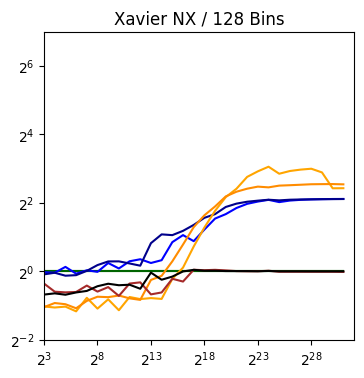

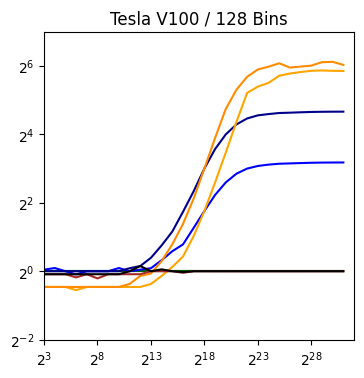

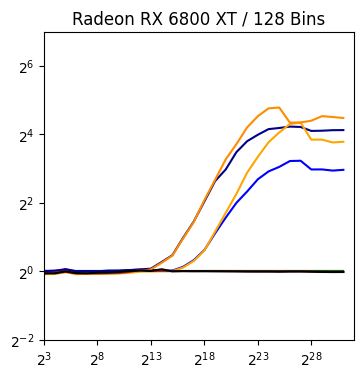

In [149]:
createSpeedupPlotsForGeneratedData(speedupsGenStat128, '128')

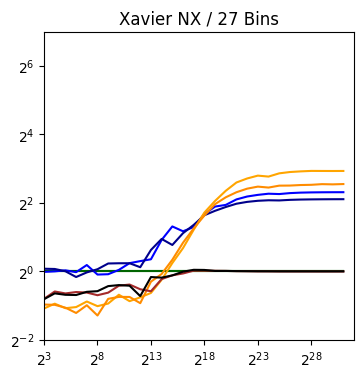

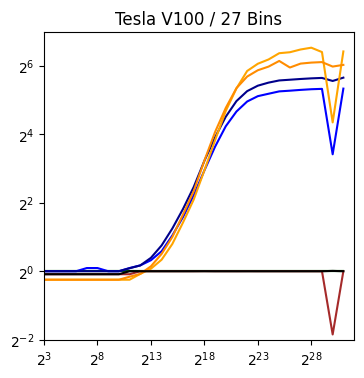

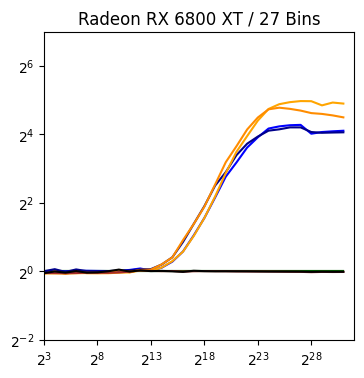

In [150]:
createSpeedupPlotsForGeneratedData(speedupsGenStatLetter, 'Letter')

In [154]:
def prepareForDivision(genStat):
    return genStat.loc[:,('timeExecution', 'med')].unstack(level=1).unstack(level=2)
letterPenalty = prepareForDivision(genStatLetter) / prepareForDivision(genStat128)

letterPenalty

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                            0.917409             1.249317   
                  16                           0.917700             0.913691   
                  32                           0.867076             0.886186   
                  64                           0.989004             0.990433   
                  128                          0.947506             1.091602   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                    3.759738             3.806672   
                  536870912                    3.809066             3.808711   
                  1073741824                   3.781273             3.801478   
                  2147483648                   3.788761             3.795913   
                  4294967296                        NaN             3.865996   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             0.910870   
                  16                            0.893381   
                  32                            0.929927   
                  64                            0.959253   
                  128                           0.851970   
...                                                  ...   
Radeon RX 6800 XT 268435456                     1.823151   
                  536870912                     1.785704   
                  1073741824                    1.707148   
                  2147483648                    1.717103   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.955849      0.980780   
                  16                                   0.849346      1.017187   
                  32                                   0.895019      0.963626   
                  64                                   0.907161      0.914198   
                  128                                  1.021037      0.917220   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                            1.726015      1.002105   
                  536870912                            1.902420      1.000103   
                  1073741824                           1.685730      0.999813   
                  2147483648                           1.747998      0.999033   
                  4294967296                           1.644426           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   1.076215       0.875262   
                  16                                  1.017399       0.942308   
                  32                                  0.964866       0.880841   
                  64                                  0.962902       0.949406   
                  128                                 0.933866       0.946165   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           1.005323       1.024608   
                  536870912                           0.995598       1.043196   
            

In [159]:
def createLetterPenaltyPlotsForGeneratedData(letterPenalty):
    grouped = letterPenalty.reset_index().groupby('device')

    col = {
        (False, 'atomic_global'): 'green',
        (True, 'atomic_global'): 'darkgreen',
        (False, 'atomic_private'): 'blue',
        (True, 'atomic_private'): 'darkblue',
        (False, 'atomic_private_stride'): 'orange',
        (True, 'atomic_private_stride'): 'darkorange',
        (False, 'atomic_global_stride'): 'brown',
        (True, 'atomic_global_stride'): 'black',
    }

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        for uniform, kernel in col.keys():
            plt.plot(grp['inputLengthInCharacters'], grp[(uniform, kernel)], color=col[(uniform, kernel)])
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
        plt.xlim(2 ** 3, 2 ** 32)
        plt.ylim(2 ** -2, 2 ** 3)
        plt.title(f'{device}')
        plt.show()

        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'executionLetterPenalty{abbrev[device]}Generated.svg'), format='svg', bbox_inches='tight')

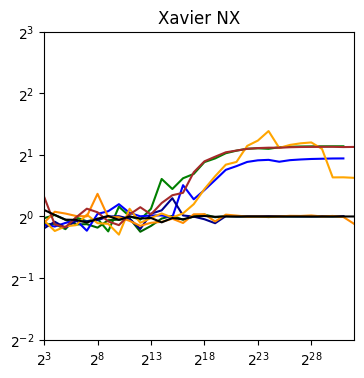

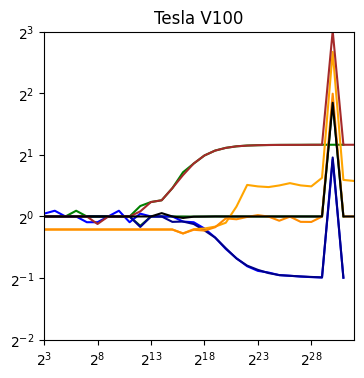

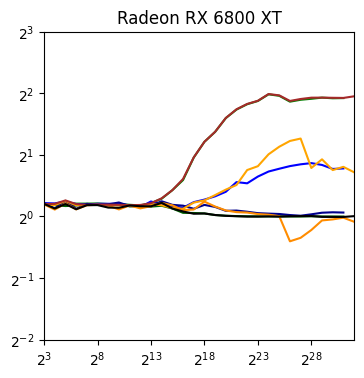

In [160]:
createLetterPenaltyPlotsForGeneratedData(letterPenalty)